## Loading Libraries

In [ ]:
!pip install igraph

     |████████████████████████████████| 3.1 MB 4.3 MB/s 


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import random
import numpy as np

import igraph
import networkx as nx
from tqdm import tqdm_notebook,tqdm
import pandas as pd

import nltk
from gensim.models import Word2Vec, Doc2Vec
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing

import random
import numpy as np
import time
import lightgbm as lgb

from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.metrics import f1_score

from xgboost import XGBClassifier

import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import StratifiedKFold


from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from tqdm import tqdm
from sklearn.metrics import (roc_curve, auc, accuracy_score)


# import numpy for Scientific computations
import numpy as np
# import machine learning libraries
from sklearn.metrics import accuracy_score
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

## Load data

In [ ]:
path_to_data = "C:/Users/ofir6/Desktop/MLNS kaggle/data/"

training_set = pd.read_table(path_to_data+"training_set.txt",sep=" ",names=["source","target","label"])
testing_set = pd.read_table(path_to_data+"testing_set.txt",sep=" ",names=["source","target"])
node_info = pd.read_csv(path_to_data+"node_information.csv",names=["id","year","title","author","classification","description"])

In [ ]:
from tqdm import tqdm, notebook
notebook.tqdm_notebook().pandas()

0it [00:00, ?it/s]

In [ ]:
node_info.head(2)

,id,year,title,author,classification,description
0,1001,2000,compactification geometry and duality,Paul S. Aspinwall,NaN,these are notes based on lectures given at tas...
1,1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...


In [ ]:
training_set.head(2)

,source,target,label
0,9510123,9502114,1
1,9707075,9604178,1


## Semantic Features

In [ ]:
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()
N_VECTORIZATION = 30

## Description

In [ ]:
#Convert a collection of raw documents to a matrix of TF-IDF features
#stop_words - that list is assumed to contain stop words, all of which will be removed from the resulting tokens
#ngram - The lower and upper boundary of the range of n-values for different n-grams to be extracted. 
#max_features - build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
#norm - ach output row will have unit norm
tfidf = TfidfVectorizer(stop_words=stpwds,ngram_range=(1,3),max_features=2000,norm="l2")
vectorized_desc = tfidf.fit_transform(list(node_info.description))

In [ ]:
#creating a corpus of all the descriptions
corpus = [element.split(" ") for element in node_info["description"]]
for i in notebook.tqdm(range(len(corpus))):
    corpus[i] = [stemmer.stem(el) for el in corpus[i] if (el.isdigit()==False and len(el)>2 and len(el)<15)]

  0%|          | 0/27770 [00:00<?, ?it/s]

In [ ]:
#creating a named tuple with words and tags
from collections import namedtuple
docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, words in notebook.tqdm(enumerate(corpus)):
    tags = [i]
    docs.append(analyzedDocument(words, tags))

0it [00:00, ?it/s]

In [ ]:
#represents each Document as a Vector using Doc2Vec
model = Doc2Vec(docs, vector_size=N_VECTORIZATION, window=8, min_count=5, workers=4)
liste = [list(model.dv[i]) for i in notebook.tqdm(range(len(model.dv)))]

  0%|          | 0/27770 [00:00<?, ?it/s]

In [ ]:
#merge the vectors to node_info data frame
node_info = node_info.merge(pd.DataFrame(liste, columns=["description_d2v_"+str(i) for i in range(N_VECTORIZATION)]),
                            how='outer', left_index=True, right_index=True)

In [ ]:
#merge the vectors to node_info data frame
#new_desc = pd.DataFrame(liste, columns=["description_d2v_"+str(i) for i in range(N_VECTORIZATION)])

## Title

In [ ]:
tfidf = TfidfVectorizer(stop_words=stpwds,ngram_range=(1,3),max_features=2000,norm="l2")

In [ ]:
vectorized_title = tfidf.fit_transform(list(node_info.title))

In [ ]:
corpus = [element.split(" ") for element in node_info["title"]]
for i in notebook.tqdm(range(len(corpus))):
    corpus[i] = [stemmer.stem(el) for el in corpus[i] if (el.isdigit()==False and len(el)>2 and len(el)<15)]

  0%|          | 0/27770 [00:00<?, ?it/s]

In [ ]:
from collections import namedtuple

docs = []

analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, words in notebook.tqdm(enumerate(corpus)):
    tags = [i]
    docs.append(analyzedDocument(words, tags))

0it [00:00, ?it/s]

In [ ]:
model = Doc2Vec(docs, vector_size=N_VECTORIZATION, window=8, min_count=5, workers=4)
liste = [list(model.dv[i]) for i in range(len(model.dv))]


In [ ]:
node_info = node_info.merge(pd.DataFrame(liste, columns=["title_d2v_"+str(i) for i in range(N_VECTORIZATION)]),how='outer', left_index=True, right_index=True)

In [ ]:
#new_title = pd.DataFrame(liste, columns=["description_d2v_"+str(i) for i in range(N_VECTORIZATION)])

## Data Cleaning

In [ ]:
def clear_name(val):
    if val!=val:
        return ""
    ar = val.split(",")
    for i in range(len(ar)):
        if ar[i][0]== " " and len(ar[i])>1: #get rid of the first space
            ar[i] = ar[i][1:]
        ar[i] = ";".join(ar[i].split(" "))
        #or ar[i] = ar[i].split(" ")[-1]
        ar[i] = ar[i].replace("(", "")
        ar[i] = ar[i].replace(")", "")
    return " ".join(ar)

node_info["author"] = node_info["author"].progress_apply(lambda val: clear_name(val))

  0%|          | 0/27770 [00:00<?, ?it/s]

In [ ]:
import string
import re
def clean_data(data):
    #punctuations
    punctuations = string.punctuation
    #digits
    digits = string.digits
    for punctuation in punctuations:
        data = data.replace(punctuation, ' ')
    for digit in digits:
        data = data.replace(digit, ' ')
    data = ' '.join(data.split())
    return data

def lemmatization(data):
    wordnet_lemmatizer = WordNetLemmatizer()
    words = data.split()
    new_data = []
    for word in words:
        word = wordnet_lemmatizer.lemmatize(word, 'v')
        new_data.append(word)
    new_data = ' '.join(new_data)
    return new_data 

stpwds = set(nltk.corpus.stopwords.words("english"))

def clean_stop(data):
    words = data.split()
    new_data = []
    for word in words:
        if word not in stpwds:
            if len(word)> 1:
                new_data.append(word)
    new_data = ' '.join(new_data)
    return new_data 

In [ ]:
node_info["pos"] = pd.Series([i for i in range(len(node_info))])

In [ ]:
training_set = training_set.merge(node_info, how="left", left_on = "source", right_on = "id")
training_set = training_set.merge(node_info, how="left", left_on = "target", right_on = "id", suffixes= ["_source","_target"])

testing_set = testing_set.merge(node_info, how="left", left_on = "source", right_on = "id")
testing_set = testing_set.merge(node_info, how="left", left_on = "target", right_on = "id", suffixes= ["_source","_target"])

In [ ]:
del(tfidf, corpus, model, analyzedDocument, docs)

In [ ]:
#training_set.columns.to_list()

## Features based on graph topology

In [ ]:
edges = training_set[training_set["label"]==1]

ig = igraph.Graph()
ig.add_vertices(node_info.id)
ig.add_edges([(source,target) for source,target in zip(edges.pos_source,edges.pos_target)])

g = nx.Graph()
g.add_nodes_from(node_info.id)
g.add_edges_from([(source,target) for source,target in zip(edges.source,edges.target)])

dg = nx.DiGraph()
dg.add_nodes_from(node_info.id)
dg.add_edges_from([(source,target) for source,target in zip(edges.source,edges.target)])

In [ ]:
def common_neighbor(line):
    n_source = set(ig.neighbors(line["pos_source"], mode="ALL"))
    n_target = set(ig.neighbors(line["pos_target"], mode="ALL"))
    return(len(n_source & n_target)>0)

training_set["common_neighbor"] = training_set.progress_apply(common_neighbor,axis=1)
testing_set["common_neighbor"] = testing_set.progress_apply(common_neighbor,axis=1)

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

In [ ]:
def jaccard(line):
    n_source = set(ig.neighbors(line["pos_source"], mode="ALL"))
    n_target = set(ig.neighbors(line["pos_target"], mode="ALL"))
    if(len(n_source) == 0 and len(n_target)==0):
        return 1
    return(len(n_source & n_target)/len(n_source | n_target))

training_set["jaccard"] = training_set.progress_apply(jaccard,axis=1)
testing_set["jaccard"] = testing_set.progress_apply(jaccard,axis=1)

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

In [ ]:
betweenness = ig.betweenness()

training_set["betweenness_source"] = training_set["pos_source"].progress_apply(lambda x : betweenness[x])
testing_set["betweenness_source"] = testing_set["pos_source"].progress_apply(lambda x : betweenness[x])

training_set["betweenness_target"] = training_set["pos_target"].progress_apply(lambda x : betweenness[x])
testing_set["betweenness_target"] = testing_set["pos_target"].progress_apply(lambda x : betweenness[x])

training_set["diff_in_bc"] = training_set["betweenness_target"] - training_set["betweenness_source"]
testing_set["diff_in_bc"] = testing_set["betweenness_target"] - testing_set["betweenness_source"]

del(betweenness)

In [ ]:
inlinks = ig.indegree()

def diff_in_inlinks(line):
    return(inlinks[line["pos_target"]]-inlinks[line["pos_source"]])

training_set["diff_in_inlinks"] = training_set.progress_apply(diff_in_inlinks,axis=1)
testing_set["diff_in_inlinks"] = testing_set.progress_apply(diff_in_inlinks,axis=1)

In [ ]:
# Cluster = connected component

cluster = ig.clusters().membership

def same_cluster(line):
    return(cluster[line["pos_target"]]-cluster[line["pos_source"]])

training_set["same_cluster"] = training_set.progress_apply(same_cluster,axis=1)
testing_set["same_cluster"] = testing_set.progress_apply(same_cluster,axis=1)

del(cluster)

In [ ]:
# Eccentricity : cumulative sum of the distance to other edges

eccentricity = ig.eccentricity(mode="IN")

def target_eccentricty(line):
    return(eccentricity[line["pos_target"]])

training_set["target_eccentricty"] = training_set.progress_apply(target_eccentricty,axis=1)
testing_set["target_eccentricty"] = testing_set.progress_apply(target_eccentricty,axis=1)

del(eccentricity)

In [ ]:
# Distance
dijsktra = nx.all_pairs_dijkstra_path_length(dg, cutoff=5)

def shortest_path(line):
    try:
        return(dijsktra[line["source"]][line["target"]])
    except:
        return(6)

training_set["shortest_path"] = training_set.progress_apply(shortest_path,axis=1)
testing_set["shortest_path"] = testing_set.progress_apply(shortest_path,axis=1)

del(dijsktra)

In [ ]:
training_set.columns.to_list()

## Features based on graph topology for the author graph

In [ ]:
#creation graph for author -> two authors are linked if one cites another
auth_list = []

for author_names in node_info["author"]:
    for name in author_names.split("_"):
        auth_list.append(name)
        
auth_list = set(auth_list)
auth_list.remove("")
auth_list = list(auth_list)

author_to_index = dict(zip(auth_list, range(len(auth_list))))

g_author = igraph.Graph()
g_author.add_vertices(len(auth_list))

lst_edges = []

auth_src_l, auth_tgt_l = training_set["author_source"], training_set["author_target"]
for i in range(len(auth_src_l)):
    auth_src = auth_src_l[i]
    auth_tgt = auth_tgt_l[i]
    
    if auth_src != "" and auth_tgt != "":
        auth_src = auth_src.split("_")
        auth_tgt = auth_tgt.split("_")
        for name_scr in auth_src:
            for name_tgt in auth_tgt:
                if name_scr != "" and name_tgt!="" and not g_author.are_connected(author_to_index[name_scr], author_to_index[name_tgt]):
                    lst_edges.append((author_to_index[name_scr], author_to_index[name_tgt]))

lst_edges = list(set(lst_edges))
g_author.add_edges(lst_edges)    
print("author graph created")

In [ ]:
betweenness = g_author.betweenness()

def auth_betweenness(elt):
    auth_list = []
    for name in elt.split("_"):
        auth_list.append(name)
    l = []
    for auth in auth_list:
        if auth != "" and auth in author_to_index:
            l.append(betweenness[author_to_index[auth]])
        else:
            l.append(0)
    return max(l)

training_set["betweenness_author_target"] = training_set["author_target"].progress_apply(auth_betweenness)
testing_set["betweenness_author_target"] = testing_set["author_target"].progress_apply(auth_betweenness)

In [ ]:
inlinks = g_author.indegree()

def auth_inlinks(elt):
    auth_list = []
    for name in elt.split("_"):
        auth_list.append(name)
    l = []
    for auth in auth_list:
        if auth != "" and auth in author_to_index:
            l.append(inlinks[author_to_index[auth]])
        else:
            l.append(0)
    return max(l)

training_set["inlinks_author_target"] = training_set["author_target"].progress_apply(auth_inlinks)
testing_set["inlinks_author_target"] = testing_set["author_target"].progress_apply(auth_inlinks)

## Semantic Features

In [ ]:
# Cos similarity in Doc2Vec title

def cos_similarity_title(line):
    scal = vectorized_title[line["pos_source"],:].dot(vectorized_title[line["pos_target"],:].T)[0,0]
    source = vectorized_title[line["pos_source"],:].dot(vectorized_title[line["pos_source"],:].T)[0,0]
    target = vectorized_title[line["pos_target"],:].dot(vectorized_title[line["pos_target"],:].T)[0,0]
    return(scal/np.sqrt(target*source))

training_set["cos_similarity_title"] = training_set.progress_apply(cos_similarity_title,axis=1)
testing_set["cos_similarity_title"] = testing_set.progress_apply(cos_similarity_title,axis=1)

In [ ]:
# Cos similarity in Doc2Vec description

def cos_similarity_description(line):
    scal = vectorized_desc[line["pos_source"],:].dot(vectorized_desc[line["pos_target"],:].T)[0,0]
    source = vectorized_desc[line["pos_source"],:].dot(vectorized_desc[line["pos_source"],:].T)[0,0]
    target = vectorized_desc[line["pos_target"],:].dot(vectorized_desc[line["pos_target"],:].T)[0,0]
    return(scal/np.sqrt(target*source))

training_set["cos_similarity_desc"] = training_set.progress_apply(cos_similarity_description,axis=1)
testing_set["cos_similarity_desc"] = testing_set.progress_apply(cos_similarity_description,axis=1)

## Attributes Features

In [ ]:
def diff_in_year(line):
    return(line["year_target"]-line["year_source"])

training_set["diff_in_year"] = training_set.progress_apply(diff_in_year,axis=1)
testing_set["diff_in_year"] = testing_set.progress_apply(diff_in_year,axis=1)

In [ ]:
def nb_common_author(line):
    set1 = list(set(line["author_source"].split(" ")))
    set2 = list(set(line["author_target"].split(" ")))
    
    set1 = list(filter(lambda a: a != "" and a!=" ", set1))
    set2 = list(filter(lambda a: a != "" and a!=" ", set2))
    
    count = 0
    for word in set1:
        for word2 in set2:
            if word in word2 or word2 in word:
                count += 1
                break
    return count


training_set["author_nb_common"] = training_set.progress_apply(nb_common_author,axis=1)
testing_set["author_nb_common"] = testing_set.progress_apply(nb_common_author,axis=1)

In [ ]:
def one_common_author(line):
    set1 = list(set(line["author_source"].split(" ")))
    set2 = list(set(line["author_target"].split(" ")))
    
    set1 = list(filter(lambda a: a != "" and a!=" ", set1))
    set2 = list(filter(lambda a: a != "" and a!=" ", set2))
    
    for word in set1:
        for word2 in set2:
            if word in word2 or word2 in word:
                return 1
    return 0

training_set["author_is_one_common"] = training_set.progress_apply(one_common_author,axis=1)
testing_set["author_is_one_common"] = testing_set.progress_apply(one_common_author,axis=1)

In [ ]:
def nb_common_classification(line):
    if line["classification_source"]!=line["classification_source"]:
        return 0
    if line["classification_target"]!=line["classification_target"]:
        return 0
    set1 = list(set(line["classification_source"].split(".")))
    set2 = list(set(line["classification_target"].split(".")))
    
    set1 = list(filter(lambda a: a != "" and a!=" ", set1))
    set2 = list(filter(lambda a: a != "" and a!=" ", set2))
    count = 0
    
    for word in set1:
        for word2 in set2:
            if (word in word2 or word2 in word):
                count += 1
                break
    return 2*count/(len(set1)+len(set2))

training_set["common_classification"] = training_set.progress_apply(nb_common_classification,axis=1)
testing_set["common_classification"] = testing_set.progress_apply(nb_common_classification,axis=1)

In [ ]:
def one_common_word(line):
    set1 = set(line["title_source"].split(" "))
    set2 = set(line["title_target"].split(" "))
    set1 = set(filter(lambda a: a != "" and a!=" ", set1))
    set2 = set(filter(lambda a: a != "" and a!=" ", set2))
    return 1 if len(set1 & set2)>0 else 0

training_set["title_is_one_common"] = training_set.progress_apply(one_common_word,axis=1)
testing_set["title_is_one_common"] = testing_set.progress_apply(one_common_word,axis=1)

In [ ]:
def nb_common_word(line):
    set1 = set(line["title_source"].split(" "))
    set2 = set(line["title_target"].split(" "))
    set1 = set(filter(lambda a: a != "" and a!=" ", set1))
    set2 = set(filter(lambda a: a != "" and a!=" ", set2))
    return len(set1 & set2)

training_set["title_nb_common_word"] = training_set.progress_apply(nb_common_word,axis=1)
testing_set["title_nb_common_word"] = testing_set.progress_apply(nb_common_word,axis=1)

In [ ]:
#pip install lightgbm

In [ ]:
#pip install xgboost

In [ ]:
N_VECTORIZATION = 30

## Preparation of the data

In [ ]:
path_to_data = "data/"

training_set = pd.read_csv(path_to_data+"improved_training_set.csv")
testing_set = pd.read_csv(path_to_data+"improved_testing_set.csv")

In [ ]:
#def cos_similarity_title_1(line):
#    scal = vectorized_title[line["pos_source"],:].dot(vectorized_title[line["pos_target"],:].T)
#    source = vectorized_title[line["pos_source"],:].dot(vectorized_title[line["pos_source"],:].T)
#    target = vectorized_title[line["pos_target"],:].dot(vectorized_title[line["pos_target"],:].T)
#    return(scal/np.sqrt(target*source))

#training_set["cos_similarity_title_1"] = training_set.progress_apply(cos_similarity_title_1,axis=1)
#testing_set["cos_similarity_title_1"] = testing_set.progress_apply(cos_similarity_title_1,axis=1)

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

#More Feature Engineering (with BERT)

### creating sentence embeddings of titles with BERT

In [ ]:
#######
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import re

documents_df=pd.DataFrame(list(node_info.title),columns=['documents'])

stop_words_l=stopwords.words('english')
documents_df['documents_cleaned']=documents_df.documents.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_l) )

#pip install sentence_transformers
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

sentence_embeddings = sbert_model.encode(documents_df['documents_cleaned'])


### cos similarity of titles with BERT

In [ ]:
def cos_similarity_title_2(line):
    scal = sentence_embeddings[line["pos_source"],:].dot(sentence_embeddings[line["pos_target"],:].T)
    source = sentence_embeddings[line["pos_source"],:].dot(sentence_embeddings[line["pos_source"],:].T)
    target = sentence_embeddings[line["pos_target"],:].dot(sentence_embeddings[line["pos_target"],:].T)
    return(scal/np.sqrt(target*source))

training_set["cos_similarity_title_2"] = training_set.progress_apply(cos_similarity_title_2,axis=1)
testing_set["cos_similarity_title_2"] = testing_set.progress_apply(cos_similarity_title_2,axis=1)

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

### Euclidean distance of titles with tfidf 

In [ ]:
def euc_dis_title_tfidf(line):
    scal = vectorized_title[line["pos_source"],:].dot(vectorized_title[line["pos_target"],:].T)[0,0]
    source = vectorized_title[line["pos_source"],:].dot(vectorized_title[line["pos_source"],:].T)[0,0]
    target = vectorized_title[line["pos_target"],:].dot(vectorized_title[line["pos_target"],:].T)[0,0]
    return(np.sqrt(source - 2 * scal + target))

training_set["euc_dis_title_tfidf"] = training_set.progress_apply(euc_dis_title_tfidf,axis=1)
testing_set["euc_dis_title_tfidf"] = testing_set.progress_apply(euc_dis_title_tfidf,axis=1)

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

### Euclidean distance of titles with BERT

In [ ]:
def euc_dis_title_bert(line):
    scal = sentence_embeddings[line["pos_source"],:].dot(sentence_embeddings[line["pos_target"],:].T)
    source = sentence_embeddings[line["pos_source"],:].dot(sentence_embeddings[line["pos_source"],:].T)
    target = sentence_embeddings[line["pos_target"],:].dot(sentence_embeddings[line["pos_target"],:].T)
    return(np.sqrt(source - 2 * scal + target))

training_set["euc_dis_title_bert"] = training_set.progress_apply(euc_dis_title_bert,axis=1)
testing_set["euc_dis_title_bert"] = testing_set.progress_apply(euc_dis_title_bert,axis=1)

### creating sentence embeddings of descriptions with BERT

In [ ]:
documents_df=pd.DataFrame(list(node_info.description),columns=['documents'])

stop_words_l=stopwords.words('english')
documents_df['documents_cleaned']=documents_df.documents.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_l) )

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

sentence_embeddings_des = sbert_model.encode(documents_df['documents_cleaned'])

### cos similarity of descriptions with BERT

In [ ]:
# Cos similarity in Doc2Vec description

def cos_similarity_description_1(line):
    scal = sentence_embeddings_des[line["pos_source"],:].dot(sentence_embeddings_des[line["pos_target"],:].T)
    source = sentence_embeddings_des[line["pos_source"],:].dot(sentence_embeddings_des[line["pos_source"],:].T)
    target = sentence_embeddings_des[line["pos_target"],:].dot(sentence_embeddings_des[line["pos_target"],:].T)
    return(scal/np.sqrt(target*source))

training_set["cos_similarity_desc_1"] = training_set.progress_apply(cos_similarity_description_1,axis=1)
testing_set["cos_similarity_desc_1"] = testing_set.progress_apply(cos_similarity_description_1,axis=1)

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

### Euclidaen distance of descriptions (BERT)

In [ ]:
def euc_dis_description_bert(line):
    scal = sentence_embeddings_des[line["pos_source"],:].dot(sentence_embeddings_des[line["pos_target"],:].T)
    source = sentence_embeddings_des[line["pos_source"],:].dot(sentence_embeddings_des[line["pos_source"],:].T)
    target = sentence_embeddings_des[line["pos_target"],:].dot(sentence_embeddings_des[line["pos_target"],:].T)
    return(np.sqrt(source - 2 * scal + target))

training_set["euc_dis_desc_bert"] = training_set.progress_apply(euc_dis_description_bert,axis=1)
testing_set["euc_dis_desc_bert"] = testing_set.progress_apply(euc_dis_description_bert,axis=1)

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

In [ ]:
# attach word_movers
dist_wordmovers_title_train = pd.read_csv("dist_wordmovers_title_train.csv")
dist_wordmovers_title_test = pd.read_csv("dist_wordmovers_title_test.csv")

frames = [training_set, dist_wordmovers_title_train['dist_wordmovers_title']]
result = pd.concat(frames, axis=1)
training_set = result
frames = [testing_set, dist_wordmovers_title_test['dist_wordmovers_title']]
result = pd.concat(frames, axis=1)
testing_set = result

### eigenvector centrality

In [ ]:
eig = ig.eigenvector_centrality()

training_set["eigenvector_source"] = training_set["pos_source"].progress_apply(lambda x : eig[x])
testing_set["eigenvector_source"] = testing_set["pos_source"].progress_apply(lambda x : eig[x])

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

### Page rank

In [ ]:
# Page Rank
page_rank = ig.pagerank()

training_set["Page_rank"] = training_set["pos_source"].progress_apply(lambda x : page_rank[x])
testing_set["Page_rank"] = testing_set["pos_source"].progress_apply(lambda x : page_rank[x])

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

### HITS

In [ ]:
# HITS algorithm
hub_score, authority_score = nx.hits(g)

training_set["hub_score"] = training_set["source"].progress_apply(lambda x : hub_score[x])
training_set["authority_score"] = training_set["target"].progress_apply(lambda x : authority_score[x])

testing_set["hub_score"] = testing_set["source"].progress_apply(lambda x : hub_score[x])
testing_set["authority_score"] = testing_set["target"].progress_apply(lambda x : authority_score[x])

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

In [ ]:
hits = nx.hits(g, max_iter=100, tol=1e-08, nstart=None, normalized=True)

training_set['hubs_s'] = training_set.source.apply(lambda x: hits[0].get(x,0))
training_set['hubs_d'] = training_set.target.apply(lambda x: hits[0].get(x,0))
training_set['authorities_s'] = training_set.source.apply(lambda x: hits[1].get(x,0))
training_set['authorities_d'] = training_set.target.apply(lambda x: hits[1].get(x,0))


testing_set['hubs_s'] = testing_set.source.apply(lambda x: hits[0].get(x,0))
testing_set['hubs_d'] = testing_set.target.apply(lambda x: hits[0].get(x,0))
testing_set['authorities_s'] = testing_set.source.apply(lambda x: hits[1].get(x,0))
testing_set['authorities_d'] = testing_set.target.apply(lambda x: hits[1].get(x,0))

### en_core_web_lg, spacy model for similarity

In [ ]:
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

In [ ]:
def en_core(line):
    title_s = nlp(line['title_source'])
    title_t = nlp(line['title_target'])
    return(title_t.similarity(title_s))

training_set["en_core"] = training_set.progress_apply(en_core,axis=1)
testing_set["en_core"] = testing_set.progress_apply(en_core,axis=1)

  0%|          | 0/615512 [00:00<?, ?it/s]

C:\Users\ofir6\AppData\Local\Temp/ipykernel_31804/3754972098.py:4: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return(title_t.similarity(title_s))


  0%|          | 0/32648 [00:00<?, ?it/s]

In [ ]:
training_set["en_core"].to_csv('en_core_train.csv')
testing_set["en_core"].to_csv('en_core_test.csv')

In [ ]:
# attach en_core_web_lg to the training set
en_core_train = pd.read_csv("en_core_train.csv")
en_core_test = pd.read_csv("en_core_test.csv")

frames = [training_set, en_core_train['en_core']]
result = pd.concat(frames, axis=1)
training_set = result
frames = [testing_set, en_core_test['en_core']]
result = pd.concat(frames, axis=1)
testing_set = result

### Allocation, Adamic-Adar, Preferential, Jaccard coefficient

In [ ]:
def alloca(line):
    a = line['source']
    b = line['target']
    allocation = nx.resource_allocation_index(g, [(a, b)])
    for u,v,p in allocation:
        score = p
    return score
def adamic_adar(line):
    a = line['source']
    b = line['target']
    adamic = nx.adamic_adar_index(g, [(a, b)])
    for u,v,p in adamic:
        score = p
    return score
def preferential(line):
    a = line['source']
    b = line['target']
    prefer = nx.preferential_attachment(g, [(a, b)])
    for u,v,p in prefer:
        score = p
    return score
def jaccard_coef(line):
    a = line['source']
    b = line['target']
    jaccard = nx.jaccard_coefficient(g, [(a, b)])
    for u,v,p in jaccard:
        score = p
    return score
    
    
training_set["allocation"] = training_set.progress_apply(alloca,axis=1)
training_set["adamic_adar"] = training_set.progress_apply(adamic_adar,axis=1)
training_set["preferential"] = training_set.progress_apply(preferential,axis=1)
training_set["jaccard_coef"] = training_set.progress_apply(jaccard_coef,axis=1)

testing_set["allocation"] = testing_set.progress_apply(alloca,axis=1)
testing_set["adamic_adar"] = testing_set.progress_apply(adamic_adar,axis=1)
testing_set["preferential"] = testing_set.progress_apply(preferential,axis=1)
testing_set["jaccard_coef"] = testing_set.progress_apply(jaccard_coef,axis=1)

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

### Jaccard, cos for followees and followers, shortest path

In [ ]:
#for followees
import math
def jaccard_for_followees(a,b):
    try:
        if len(set(dg.successors(a))) == 0  | len(set(dg.successors(b))) == 0:
            return 0
        sim = (len(set(dg.successors(a)).intersection(set(dg.successors(b)))))/\
                                    (len(set(dg.successors(a)).union(set(dg.successors(b)))))
    except:
        return 0
    return sim

def jaccard_for_followers(a,b):
    try:
        if len(set(dg.predecessors(a))) == 0  | len(set(dg.predecessors(b))) == 0:
            return 0
        sim = (len(set(dg.predecessors(a)).intersection(set(dg.predecessors(b)))))/\
                                 (len(set(dg.predecessors(a)).union(set(dg.predecessors(b)))))
        return sim
    except:
        return 0
    
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(dg.successors(a))) == 0  | len(set(dg.successors(b))) == 0:
            return 0
        sim = (len(set(dg.successors(a)).intersection(set(dg.successors(b)))))/\
                                    (math.sqrt(len(set(dg.successors(a)))*len((set(dg.successors(b))))))
        return sim
    except:
        return 0
def cosine_for_followers(a,b):
    try:
        
        if len(set(dg.predecessors(a))) == 0  | len(set(dg.predecessors(b))) == 0:
            return 0
        sim = (len(set(dg.predecessors(a)).intersection(set(dg.predecessors(b)))))/\
                                     (math.sqrt(len(set(dg.predecessors(a))))*(len(set(dg.predecessors(b)))))
        return sim
    except:
        return 0
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if dg.has_edge(a,b):
            dg.remove_edge(a,b)
            p= nx.shortest_path_length(dg,source=a,target=b)
            dg.add_edge(a,b)
        else:
            p= nx.shortest_path_length(dg,source=a,target=b)
        return p
    except:
        return -1
    
#getting weakly connected edges from graph 
wcc=list(nx.weakly_connected_components(dg))
def belongs_to_same_wcc(a,b):
    index = []
    if dg.has_edge(b,a):
        return 1
    if dg.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                dg.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    dg.add_edge(a,b)
                    return 0
                else:
                    dg.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0
def follows_back(a,b):
    if dg.has_edge(b,a):
        return 1
    else:
        return 0

### katz_centrality

In [ ]:
katz = nx.katz.katz_centrality(g,alpha=0.005,beta=1)
pr = nx.pagerank(g, alpha=0.85)
mean_pr=float(sum(pr.values())) / len(pr)
mean_katz = float(sum(katz.values())) / len(katz)

In [ ]:
training_set['jaccard_followers'] = training_set.apply(lambda row:jaccard_for_followers(row['source'],row['target']),axis=1)
training_set['jaccard_followees'] = training_set.apply(lambda row:jaccard_for_followees(row['source'],row['target']),axis=1)
training_set['cosine_followers'] = training_set.apply(lambda row: cosine_for_followers(row['source'],row['target']),axis=1)
training_set['cosine_followees'] = training_set.apply(lambda row: cosine_for_followees(row['source'],row['target']),axis=1)
training_set['follows_back'] = training_set.apply(lambda row: follows_back(row['source'],row['target']),axis=1)
training_set['same_comp'] = training_set.apply(lambda row: belongs_to_same_wcc(row['source'],row['target']),axis=1)
training_set['shortest_path'] = training_set.apply(lambda row: compute_shortest_path_length(row['source'],row['target']),axis=1)
training_set['page_rank_s'] = training_set.source.apply(lambda x:pr.get(x,mean_pr))
training_set['page_rank_d'] = training_set.target.apply(lambda x:pr.get(x,mean_pr))
training_set['katz_s'] = training_set.source.apply(lambda x: katz.get(x,mean_katz))
training_set['katz_d'] = training_set.target.apply(lambda x: katz.get(x,mean_katz))

testing_set['jaccard_followers'] = testing_set.apply(lambda row:jaccard_for_followers(row['source'],row['target']),axis=1)
testing_set['jaccard_followees'] = testing_set.apply(lambda row:jaccard_for_followees(row['source'],row['target']),axis=1)
testing_set['cosine_followers'] = testing_set.apply(lambda row: cosine_for_followers(row['source'],row['target']),axis=1)
testing_set['cosine_followees'] = testing_set.apply(lambda row: cosine_for_followees(row['source'],row['target']),axis=1)
testing_set['follows_back'] = testing_set.apply(lambda row: follows_back(row['source'],row['target']),axis=1)
testing_set['same_comp'] = testing_set.apply(lambda row: belongs_to_same_wcc(row['source'],row['target']),axis=1)
testing_set['shortest_path'] = testing_set.apply(lambda row: compute_shortest_path_length(row['source'],row['target']),axis=1)
testing_set['page_rank_s'] = testing_set.source.apply(lambda x:pr.get(x,mean_pr))
testing_set['page_rank_d'] = testing_set.target.apply(lambda x:pr.get(x,mean_pr))
testing_set['katz_s'] = testing_set.source.apply(lambda x: katz.get(x,mean_katz))
testing_set['katz_d'] = testing_set.target.apply(lambda x: katz.get(x,mean_katz))

### num of follwers and followees



In [ ]:
def compute_features_stage1(training_set):
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in training_set.iterrows():
        try:
            s1=set(dg.predecessors(row['source']))
            s2=set(dg.successors(row['source']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(dg.predecessors(row['target']))
            d2=set(dg.successors(row['target']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [ ]:
training_set['num_followers_s'], training_set['num_followers_d'], \
training_set['num_followees_s'], training_set['num_followees_d'], \
training_set['inter_followers'], training_set['inter_followees'] = compute_features_stage1(training_set)

testing_set['num_followers_s'], testing_set['num_followers_d'], \
testing_set['num_followees_s'], testing_set['num_followees_d'], \
testing_set['inter_followers'], testing_set['inter_followees'] = compute_features_stage1(testing_set)

In [ ]:
# dimension of vector (word embedding)
#frames = [training_set, new_train]
#result = pd.concat(frames, axis=1)
#training_set = result

#frames = [testing_set, new_test]
#result = pd.concat(frames, axis=1)
#testing_set = result

### Harmonic

In [ ]:
harmonic = nx.harmonic_centrality(g)
#(pd.DataFrame.from_dict(data=harmonic, orient='index').to_csv('harmonic_1.csv', header=False))

In [ ]:
training_set["harmonic_s"] = training_set["source"].progress_apply(lambda x : harmonic[x])
training_set["harmonic_t"] = training_set["target"].progress_apply(lambda x : harmonic[x])

testing_set["harmonic_s"] = testing_set["source"].progress_apply(lambda x : harmonic[x])
testing_set["harmonic_t"] = testing_set["target"].progress_apply(lambda x : harmonic[x])

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/615512 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

  0%|          | 0/32648 [00:00<?, ?it/s]

### jaccard between words in descriptions

In [ ]:
from nltk.tokenize import word_tokenize
def calculate_jaccard(word_tokens1, word_tokens2):
    both_tokens = word_tokens1 + word_tokens2
    union = set(both_tokens)

# Calculate intersection.
    intersection = set()
    for w in word_tokens1:
        if w in word_tokens2:
            intersection.add(w)

    jaccard_score = len(intersection)/len(union)
    return jaccard_score

def desc_jaccard(line):
    a = word_tokenize(line['description_source'])
    b = word_tokenize(line['description_target'])
    return calculate_jaccard(a,b)

training_set['desc_jaccard'] = training_set.progress_apply(desc_jaccard,axis=1)
testing_set['desc_jaccard'] = testing_set.progress_apply(desc_jaccard,axis=1)
training_set['desc_jaccard'].to_csv('desc_jacc_train.csv')
testing_set['desc_jaccard'].to_csv('desc_jacc_test.csv')

### Universal Sentence Encoder's TF Hub module

In [ ]:
# Make all the capital letters small
node_info['n_desc'] = node_info['description'].str.lower()
node_info['n_desc'] = node_info['n_desc'].apply(lambda x: clean_data(x)) 
for x in node_info['n_desc']:
    x = re.sub('[^a-zA-Z]', ' ', x)
node_info['n_desc'] = node_info['n_desc'].apply(lambda x: re.sub('\W+', ' ', x))
node_info['n_desc'] = node_info['n_desc'].apply(lambda x: lemmatization(x))
node_info['n_desc'] = node_info['n_desc'].apply(lambda x: clean_stop(x))

In [ ]:
#title Load the Universal Sentence Encoder's TF Hub module
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
model = hub.load(module_url)

In [ ]:
def process_text(text):
    text = text.encode('ascii', errors='ignore').decode()
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'#+', ' ', text )
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    text = re.sub(r"([A-Za-z]+)'s", r"\1 is", text)
    #text = re.sub(r"\'s", " ", text)     text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"won't", "will not ", text)
    text = re.sub(r"isn't", "is not ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    return text

In [ ]:
def universal(line):
    source = line['n_desc']
    temp = []
    temp.append(process_text(source))
    embeddings = model(temp)
    return embeddings[0]

node_info['universal'] = node_info.progress_apply(universal, axis=1)

In [ ]:
def cosine_similarity(v1, v2):
    mag1 = np.linalg.norm(v1)
    mag2 = np.linalg.norm(v2)
    if (not mag1) or (not mag2):
        return 0
    return np.dot(v1, v2) / (mag1 * mag2)

In [ ]:
def univ(line):
    pos_source = line['pos_source']
    pos_target = line['pos_target']
    vec1 = node_info['universal'][pos_source]
    vec2 = node_info['universal'][pos_target]
    return cosine_similarity(vec1, vec2)

training_set['universal'] = training_set.progress_apply(univ, axis = 1)
testing_set['universal'] = testing_set.progress_apply(univ, axis = 1)

#Load improved DataSets

In [ ]:
#training_set.to_csv(path_to_data+"improved_training_set_3.csv")
#testing_set.to_csv(path_to_data+"improved_testing_set_3.csv")
path_to_data = "data/"

training_set = pd.read_csv(path_to_data+"improved_training_set_3.csv")
testing_set = pd.read_csv(path_to_data+"improved_testing_set_3.csv")

In [ ]:
# attach universal
univ_train = pd.read_csv("universal_train.csv")
univ_test = pd.read_csv("universal_test.csv")

frames = [training_set, univ_train['universal']]
result = pd.concat(frames, axis=1)
training_set = result
frames = [testing_set, univ_test['universal']]
result = pd.concat(frames, axis=1)
testing_set = result

In [ ]:
# attach jaccard
desc_jacc_train = pd.read_csv("desc_jacc_train.csv")
desc_jacc_test = pd.read_csv("desc_jacc_test.csv")

frames = [training_set, desc_jacc_train['desc_jaccard']]
result = pd.concat(frames, axis=1)
training_set = result
frames = [testing_set, desc_jacc_test['desc_jaccard']]
result = pd.concat(frames, axis=1)
testing_set = result

### correlation

In [ ]:
training_set[['label', 'common_neighbor', 'same_cluster', 'jaccard', 'diff_in_bc',
             'diff_in_inlinks', 'diff_in_year', 'author_nb_common','author_is_one_common',
             'common_classification', 'title_is_one_common', 'title_nb_common_word',
             'cos_similarity_title', 'cos_similarity_desc', 'cos_similarity_title_2',
              'cos_similarity_desc_1', 'euc_dis_title_bert',
             'euc_dis_desc_bert', 'target_eccentricty', 'betweenness_author_target',
             'inlinks_author_target', 'en_core', 'hub_score', 'authority_score',
              'hubs_s','hubs_d','authorities_s', 'authorities_d',
             'allocation', 'adamic_adar', 'preferential', 'jaccard_coef',
              'harmonic_s', 'harmonic_t', 'jaccard_followers', 'jaccard_followees',
              'cosine_followers', 'cosine_followees', 'follows_back', 'same_comp',
              'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d', 'num_followers_s',
              'num_followers_d', 'num_followees_s', 'num_followees_d', 'inter_followers',
              'inter_followees', 'universal','desc_jaccard']].corr()['label'][:]

label                        1.000000
common_neighbor              0.911748
same_cluster                 0.001237
jaccard                      0.581025
diff_in_bc                   0.136187
diff_in_inlinks              0.205395
diff_in_year                -0.298960
author_nb_common             0.130071
author_is_one_common         0.145108
common_classification        0.156298
title_is_one_common          0.200877
title_nb_common_word         0.285134
cos_similarity_title         0.343256
cos_similarity_desc          0.559010
cos_similarity_title_2       0.206094
cos_similarity_desc_1        0.308578
euc_dis_title_bert          -0.221648
euc_dis_desc_bert           -0.322953
target_eccentricty          -0.202825
betweenness_author_target    0.142262
inlinks_author_target        0.214047
en_core                      0.178434
hub_score                    0.219285
authority_score              0.249057
hubs_s                       0.219285
hubs_d                       0.249057
authorities_

In [ ]:
N_VECTORIZATION = 30
selected_features = ["description_d2v_"+str(i)+"_source" for i in range(N_VECTORIZATION)]+["description_d2v_"+str(i)+"_target" for i in range(N_VECTORIZATION)]
selected_features += ["title_d2v_"+str(i)+"_source" for i in range(N_VECTORIZATION)]+["title_d2v_"+str(i)+"_target" for i in range(N_VECTORIZATION)]
selected_features += ["common_neighbor",
                     "same_cluster",
                     #"jaccard",
                     "diff_in_bc",
                     "diff_in_inlinks",
                     "diff_in_year",
                     "author_nb_common",
                     "author_is_one_common",
                     "common_classification",
                     "title_is_one_common",
                     "title_nb_common_word",
                     "cos_similarity_title",  #tfidf
                     "cos_similarity_desc", #### #tfidf
                     #'cos_similarity_title_2', #bert
                     #'cos_similarity_desc_1', #bert
                     'euc_dis_title_bert', #eucl bert
                     'euc_dis_desc_bert', #eucl bert
                     "target_eccentricty",
                     #'inlinks_target', ##
                     'betweenness_author_target',
                     'inlinks_author_target',
                     'en_core',
                      'hub_score',
                      'authority_score',
                      #'hubs_s',
                      #'hubs_d',
                      #'authorities_s',
                      #'authorities_d',
                      'allocation',
                      'adamic_adar',
                      'preferential',
                       #'jaccard_coef',
                       #'harmonic_s',
                       #'harmonic_t',
                      'jaccard_followers',
                      'jaccard_followees',
                      'cosine_followers',
                      'cosine_followees',
                      #'follows_back',
                      #'same_comp',
                      #'page_rank_s',
                      #'page_rank_d',
                      #'katz_s',
                      #'katz_d',
                      #'num_followers_s',
                      #'num_followers_d',
                      #'num_followees_s',
                      #'num_followees_d',
                      #'inter_followers',
                      #'inter_followees',
                      'universal',
                      'desc_jaccard'
                      #'dist_wordmovers_title',
                      #'eigenvector_source',
                      #'Page_rank'
                      #'shortest_path'   ###
                     #'cos_similarity_tf_title', ##
                     #'cos_similarity_tf_description', ##
                      
                    ]

print(len(selected_features))

149


In [ ]:
#X["common_neighbor"] = X["common_neighbor"].astype(int)

In [ ]:
#new_x = X.values.astype(np.float)

In [ ]:
#(X.cos_similarity_title < 0).any()
#X = X.reset_index()
#X.replace([np.inf, -np.inf], np.nan, inplace=True)
#X['cos_similarity_title'].isin([np.nan, np.inf, -np.inf]).any()

### features selection

In [ ]:
selected_features = ['common_neighbor', 'same_cluster', 'jaccard', 'diff_in_bc',
             'diff_in_inlinks', 'diff_in_year', 'author_nb_common','author_is_one_common',
             'common_classification', 'title_is_one_common', 'title_nb_common_word',
             'cos_similarity_title', 'cos_similarity_desc', 'euc_dis_title_bert',
             'euc_dis_desc_bert', 'target_eccentricty', 'betweenness_author_target',
             'inlinks_author_target', 'en_core', 'hub_score', 'authority_score',
              'hubs_s','hubs_d','authorities_s', 'authorities_d',
             'allocation', 'adamic_adar', 'preferential', 'jaccard_coef',
              'harmonic_s', 'harmonic_t', 'jaccard_followers', 'jaccard_followees',
              'cosine_followers', 'cosine_followees', 'follows_back', 'same_comp',
              'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d', 'num_followers_s',
              'num_followers_d', 'num_followees_s', 'num_followees_d', 'inter_followers',
              'inter_followees']

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = training_set[selected_features]  #independent columns
y = training_set.label    #target column i.e price range

In [ ]:
X.fillna(0, inplace=True)

C:\Users\ofir6\Anaconda3\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [ ]:
from sklearn import preprocessing

x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled, columns = X.columns)

In [ ]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=30)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

                        Specs          Score
0             common_neighbor  238501.988822
34           cosine_followees   44940.721057
28               jaccard_coef   33046.101747
2                     jaccard   29069.472094
32          jaccard_followees   25090.154450
11       cos_similarity_title   23256.426383
12        cos_similarity_desc   21161.346064
31          jaccard_followers   17499.448765
42            num_followers_d   12063.024721
40                     katz_d   11525.636522
33           cosine_followers   11496.978800
9         title_is_one_common   11373.036025
7        author_is_one_common   11346.392852
46            inter_followees   10262.509725
24              authorities_d   10235.337427
20            authority_score   10235.337427
22                     hubs_d   10235.337427
38                page_rank_d    9679.373024
8       common_classification    6833.834663
17      inlinks_author_target    6167.405702
10       title_nb_common_word    5791.311379
43        

[4.87616209e-01 4.31356788e-03 4.50532773e-02 3.63742571e-03
 4.68339019e-03 2.56122522e-02 7.20143454e-04 2.46753449e-03
 2.36465024e-03 5.08437953e-03 3.25949874e-03 1.77666533e-02
 3.48829472e-02 3.86104797e-03 8.08072908e-03 9.86435304e-03
 3.24428329e-03 4.79188205e-03 2.71440753e-03 3.46048831e-03
 7.45784806e-03 2.78469649e-03 7.75259296e-03 4.16116620e-03
 8.79823677e-03 1.62306362e-02 1.23578221e-02 3.58120277e-03
 4.40820625e-02 1.23078138e-02 1.93578678e-02 1.44758417e-02
 2.74648951e-02 8.73591264e-03 3.98154563e-02 5.67117265e-05
 2.98342183e-02 2.44127996e-03 1.16567990e-02 5.02001572e-03
 8.47756732e-03 2.23770798e-03 1.81272607e-02 5.11761675e-03
 3.30784184e-03 1.58315964e-03 9.29664893e-03]


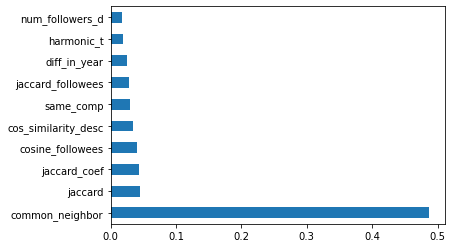

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
#sklearn.feature_selection.f_classif 
#sklearn.feature_selection.mutual_info_classif 

In [ ]:
N_VECTORIZATION = 30
selected_features = ["description_d2v_"+str(i)+"_source" for i in range(N_VECTORIZATION)]+["description_d2v_"+str(i)+"_target" for i in range(N_VECTORIZATION)]
selected_features += ["title_d2v_"+str(i)+"_source" for i in range(N_VECTORIZATION)]+["title_d2v_"+str(i)+"_target" for i in range(N_VECTORIZATION)]
selected_features += featureScores.nlargest(30,'Score').Specs.tolist()[:35]

In [ ]:
selected_features = ['common_neighbor', 'cosine_followees', 'jaccard_coef', 'jaccard', 
 'jaccard_followees', 'cos_similarity_title', 'cos_similarity_desc', 
 'jaccard_followers', 'num_followers_d', 'katz_d', 'cosine_followers', 
 'title_is_one_common', 'author_is_one_common', 'inter_followees', 
 'authorities_d', 'authority_score', 'hubs_d', 'page_rank_d', 'common_classification', 
 'inlinks_author_target', 'title_nb_common_word', 'num_followees_s', 
 'betweenness_author_target', 'diff_in_year', 'harmonic_t', 'author_nb_common', 
 'hub_score', 'hubs_s', 'authorities_s', 'adamic_adar', 'harmonic_s', 'katz_s',  'allocation', 'num_followees_d']
#,'same_comp'

### Split to train and test

In [ ]:
X_train, X_test, Y_train = training_set[selected_features],testing_set[selected_features],training_set.label
#del (training_set,testing_set)

In [ ]:
# run this only if using the above feature selection

x = X_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_train = pd.DataFrame(x_scaled, columns = X_train.columns)
x = X_test.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_test = pd.DataFrame(x_scaled, columns = X_test.columns)

Different Results with Different Combination of features
1. all except shortest_path   -   0.97477
2. all withouht bert cos_sim   -   0.9748
3. all withouht bert cos_sim and shortestpath   -   0.97484
4. all, withouht bert cos_sim and shortestpath, with dist_wordmovers_title  -  0.9747
5. all, withouht bert cos_sim and shortestpath and dist_wordmovers_title, with page rank and eigen -
6. like 3 but with 50 vector - 
7. only tf idf and en_core - 0.9745
8. only tf idf and en_core with alloc,adami,prefer - 0.97748
9. with all the features (no bert cos_sim, hub aut score) - 0.9861
11. like 9 un until jaccard_coef + cosine_follow -  0.9775
12. only tf idf and en_core with alloc,adami,prefer,jaccard - 0.97754
13. like 8 with harmonic on source - 0.97768

#Modelling

## LGBM

In [ ]:
# Parameters for lgbm
        
parameters = {
        'application': 'binary',
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': 'true',
        'boosting': 'gbdt', #'dart'
        'num_leaves': 80,
        'feature_fraction': 0.7,
        'min_data_in_leaf': 500,
        'learning_rate': 0.1,
        'num_iterations': 500,
        'max_bin': 255,
        #'max_bin': 510,
        'verbosity': -2,
        'lambda_l1': 10, # L1 regularization
        'lambda_l2': 10, # L2 regularization
        }

In [ ]:
average_score = 0
n_splits = 5
prediction = [] #final prediction on X_test after Kfold

skf = StratifiedKFold(n_splits=n_splits)
for train_index, test_index in skf.split(X_train, Y_train):
    sub_X_train, sub_X_test = X_train.iloc[train_index], X_train.iloc[test_index]
    sub_Y_train, sub_Y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]
        
    lgb_train = lgb.Dataset(sub_X_train, sub_Y_train)
    lgb_eval = lgb.Dataset(sub_X_test, sub_Y_test, reference=lgb_train)
    
    rfc = lgb.train(parameters,
                       lgb_train,
                       valid_sets=lgb_eval,
                       num_boost_round=5000,
                       early_stopping_rounds=100,
                       verbose_eval=False)
    
    #prediction_sub is the prediction on the validation set
    prediction_sub = rfc.predict(sub_X_test)
    
    #prediction_test is the prediction on the testing set
    prediction_test = rfc.predict(X_test)
    
    prediction_sub = [1 if p>0.5 else 0 for p in prediction_sub]
    
    score_tmp = f1_score(sub_Y_test, prediction_sub)
    average_score += score_tmp
    print("f1 score is for this fold :", score_tmp)
    
    # Combination with previous fold
    if len(prediction)==0:
        prediction = prediction_test
    prediction += prediction_test
        
    del(sub_X_train, sub_X_test, sub_Y_train, sub_Y_test, prediction_sub, prediction_test)
    
prediction = [1 if p>=n_splits/2 else 0 for p in prediction]
print("final f1 score is", average_score/n_splits)

C:\Users\ofir6\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ofir6\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] Number of positive: 268104, number of negative: 224305
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36009
[LightGBM] [Info] Number of data points in the train set: 492409, number of used features: 149
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544474 -> initscore=0.178368
[LightGBM] [Info] Start training from score 0.178368
f1 score is for this fold : 0.9779051104744476


C:\Users\ofir6\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ofir6\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] Number of positive: 268104, number of negative: 224305
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.279742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36010
[LightGBM] [Info] Number of data points in the train set: 492409, number of used features: 149
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544474 -> initscore=0.178368
[LightGBM] [Info] Start training from score 0.178368
f1 score is for this fold : 0.9786324465811164


C:\Users\ofir6\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ofir6\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] Number of positive: 268104, number of negative: 224306
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.308873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36011
[LightGBM] [Info] Number of data points in the train set: 492410, number of used features: 149
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544473 -> initscore=0.178364
[LightGBM] [Info] Start training from score 0.178364
f1 score is for this fold : 0.9781769384741099


C:\Users\ofir6\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ofir6\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] Number of positive: 268104, number of negative: 224306
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.346130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36009
[LightGBM] [Info] Number of data points in the train set: 492410, number of used features: 149
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544473 -> initscore=0.178364
[LightGBM] [Info] Start training from score 0.178364
f1 score is for this fold : 0.9783300318146347


C:\Users\ofir6\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ofir6\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] Number of positive: 268104, number of negative: 224306
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.316658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36009
[LightGBM] [Info] Number of data points in the train set: 492410, number of used features: 149
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544473 -> initscore=0.178364
[LightGBM] [Info] Start training from score 0.178364


In [ ]:
df_sub = pd.DataFrame(prediction, columns=["category"])
df_sub.to_csv('output_new_22.csv', float_format='%.6f', index_label="ID")

print("done.")

### LGBM Trial 2

In [ ]:
parameters = {
        'application': 'binary',
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': 'true',
        'boosting': 'gbdt', #'dart'
        'num_leaves': 80,
        'feature_fraction': 0.7,
        'min_data_in_leaf': 500,
        'learning_rate': 0.1,
        'num_iterations': 500,
        'max_bin': 255,
        #'max_bin': 510,
        'verbosity': -2,
        'lambda_l1': 10, # L1 regularization
        'lambda_l2': 10, # L2 regularization
        }

    
# Initiate classifier to use
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'])

# To view the default model parameters:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin'])

In [ ]:
params = {
        'application': 'binary',
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': 'true',
        'boosting': 'gbdt', #'dart'
        'num_leaves': 80,
        'feature_fraction': 0.7,
        'min_data_in_leaf': 500,
        'learning_rate': 0.1,
        'num_iterations': 500,
        'max_bin': 255,
        #'max_bin': 510,
        'verbosity': -2,
        'lambda_l1': 10, # L1 regularization
        'lambda_l2': 10, # L2 regularization
        }

mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 5, 
          silent = True,
          learning_rate = params['learning_rate'])

In [ ]:
gridParams = {
    'learning_rate': [0.01, 0.05, 0.075, 0.1, 0.15]}

In [ ]:
gridParams = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [8,16,24],
    'num_leaves': [40,80,120], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['binary'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

In [ ]:
X, y = training_set[selected_features], training_set.label
grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)
# Run the grid
grid.fit(X, y)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

## XGBOOST

In [ ]:
#pip install xgboost

In [ ]:
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
#from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [ ]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


Error processing line 1 of C:\Users\ofir6\Anaconda3\lib\site-packages\vision-1.0.0-py3.9-nspkg.pth:

  Traceback (most recent call last):
    File "C:\Users\ofir6\Anaconda3\lib\site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


###Hyperparameter Tuning

In [ ]:
X = training_set[selected_features]

In [ ]:
#np.where(X.values >= np.finfo(np.float64).max)
X = X.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [ ]:
y = training_set.label

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [ ]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9476372025517996                                                                                                     
  1%|▍                                              | 1/100 [00:18<30:32, 18.51s/trial, best loss: -0.9476372025517996]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.947929641383344                                                                                                      
  2%|▉                                               | 2/100 [00:39<32:38, 19.98s/trial, best loss: -0.947929641383344]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9476209559500471                                                                                                     
  3%|█▍                                              | 3/100 [01:05<36:41, 22.69s/trial, best loss: -0.947929641383344]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.947707604492727                                                                                                      
  4%|█▉                                              | 4/100 [01:26<35:08, 21.97s/trial, best loss: -0.947929641383344]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9476805268231395                                                                                                     
  5%|██▍                                             | 5/100 [01:47<34:20, 21.69s/trial, best loss: -0.947929641383344]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9473664258559251                                                                                                     
  6%|██▉                                             | 6/100 [02:09<33:56, 21.66s/trial, best loss: -0.947929641383344]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9479783811886013                                                                                                     
  7%|███▎                                           | 7/100 [02:33<34:48, 22.46s/trial, best loss: -0.9479783811886013]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9476805268231395                                                                                                     
  8%|███▊                                           | 8/100 [02:56<34:52, 22.75s/trial, best loss: -0.9479783811886013]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9474584899325225                                                                                                     
  9%|████▏                                          | 9/100 [03:18<34:08, 22.51s/trial, best loss: -0.9479783811886013]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9473880879915951                                                                                                     
 10%|████▌                                         | 10/100 [03:40<33:37, 22.42s/trial, best loss: -0.9479783811886013]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9477780064336543                                                                                                     
 11%|█████                                         | 11/100 [04:01<32:22, 21.83s/trial, best loss: -0.9479783811886013]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9477725908997368                                                                                                     
 12%|█████▌                                        | 12/100 [04:24<32:44, 22.33s/trial, best loss: -0.9479783811886013]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9477130200266445                                                                                                     
 13%|█████▉                                        | 13/100 [04:45<31:54, 22.00s/trial, best loss: -0.9479783811886013]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9477346821623144                                                                                                     
 14%|██████▍                                       | 14/100 [05:13<33:51, 23.63s/trial, best loss: -0.9479783811886013]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9473772569237601                                                                                                     
 15%|██████▉                                       | 15/100 [05:38<34:01, 24.01s/trial, best loss: -0.9479783811886013]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9477617598319018                                                                                                     
 16%|███████▎                                      | 16/100 [06:01<33:19, 23.80s/trial, best loss: -0.9479783811886013]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9476534491535521                                                                                                     
 17%|███████▊                                      | 17/100 [06:28<34:06, 24.65s/trial, best loss: -0.9479783811886013]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9475830472126247                                                                                                     
 18%|████████▎                                     | 18/100 [06:52<33:24, 24.44s/trial, best loss: -0.9479783811886013]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9473664258559251                                                                                                     
 19%|████████▋                                     | 19/100 [07:12<31:31, 23.35s/trial, best loss: -0.9479783811886013]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9474205811951                                                                                                        
 20%|█████████▏                                    | 20/100 [07:37<31:35, 23.69s/trial, best loss: -0.9479783811886013]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9479458879850965                                                                                                     
 21%|█████████▋                                    | 21/100 [08:00<30:55, 23.49s/trial, best loss: -0.9479783811886013]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9480758607991162                                                                                                     
 22%|██████████                                    | 22/100 [08:24<30:43, 23.64s/trial, best loss: -0.9480758607991162]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9481516782739611                                                                                                     
 23%|██████████▌                                   | 23/100 [08:46<29:50, 23.26s/trial, best loss: -0.9481516782739611]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9481787559435485                                                                                                     
 24%|███████████                                   | 24/100 [09:11<30:07, 23.78s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9478321617728291                                                                                                     
 25%|███████████▌                                  | 25/100 [09:33<28:58, 23.18s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9481516782739611                                                                                                     
 26%|███████████▉                                  | 26/100 [09:55<28:12, 22.87s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.947875486044169                                                                                                      
 27%|████████████▍                                 | 27/100 [10:18<27:47, 22.85s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9481246006043735                                                                                                     
 28%|████████████▉                                 | 28/100 [10:43<28:16, 23.57s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.947897148179839                                                                                                      
 29%|█████████████▎                                | 29/100 [11:10<28:50, 24.37s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.947875486044169                                                                                                      
 30%|█████████████▊                                | 30/100 [11:34<28:20, 24.29s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9476913578909745                                                                                                     
 31%|██████████████▎                               | 31/100 [12:00<28:34, 24.85s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9479133947815915                                                                                                     
 32%|██████████████▋                               | 32/100 [12:22<27:24, 24.19s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.947696773424892                                                                                                      
 33%|███████████████▏                              | 33/100 [12:44<26:09, 23.42s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9477563442979844                                                                                                     
 34%|███████████████▋                              | 34/100 [13:12<27:19, 24.84s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.947940472451179                                                                                                      
 35%|████████████████                              | 35/100 [13:34<25:46, 23.80s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9475018142038624                                                                                                     
 36%|████████████████▌                             | 36/100 [13:58<25:38, 24.04s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9477509287640669                                                                                                     
 37%|█████████████████                             | 37/100 [14:24<25:39, 24.44s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9477455132301493                                                                                                     
 38%|█████████████████▍                            | 38/100 [14:48<25:12, 24.40s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9475938782804597                                                                                                     
 39%|█████████████████▉                            | 39/100 [15:12<24:35, 24.18s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9481300161382911                                                                                                     
 40%|██████████████████▍                           | 40/100 [15:35<23:53, 23.88s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9476372025517996                                                                                                     
 41%|██████████████████▊                           | 41/100 [15:57<23:02, 23.44s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9479025637137566                                                                                                     
 42%|███████████████████▎                          | 42/100 [16:18<22:01, 22.79s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.94744224333077                                                                                                       
 43%|███████████████████▊                          | 43/100 [16:39<21:09, 22.27s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9477563442979844                                                                                                     
 44%|████████████████████▏                         | 44/100 [17:02<20:49, 22.32s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9476101248822122                                                                                                     
 45%|████████████████████▋                         | 45/100 [17:27<21:09, 23.08s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9481191850704561                                                                                                     
 46%|█████████████████████▏                        | 46/100 [17:50<20:54, 23.23s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9475126452716973                                                                                                     
 47%|█████████████████████▌                        | 47/100 [18:15<20:49, 23.57s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9477455132301493                                                                                                     
 48%|██████████████████████                        | 48/100 [18:37<19:58, 23.04s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9475776316787072                                                                                                     
 49%|██████████████████████▌                       | 49/100 [18:56<18:35, 21.88s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9476263714839646                                                                                                     
 50%|███████████████████████                       | 50/100 [19:21<19:06, 22.92s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9477400976962319                                                                                                     
 51%|███████████████████████▍                      | 51/100 [19:48<19:46, 24.21s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9475072297377799                                                                                                     
 52%|███████████████████████▉                      | 52/100 [20:14<19:50, 24.80s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9478700705102516                                                                                                     
 53%|████████████████████████▍                     | 53/100 [20:36<18:38, 23.79s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9479892122564364                                                                                                     
 54%|████████████████████████▊                     | 54/100 [20:59<18:04, 23.58s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9479729656546839                                                                                                     
 55%|█████████████████████████▎                    | 55/100 [21:22<17:35, 23.46s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9477130200266445                                                                                                     
 56%|█████████████████████████▊                    | 56/100 [21:48<17:41, 24.14s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9479242258494265                                                                                                     
 57%|██████████████████████████▏                   | 57/100 [22:09<16:44, 23.37s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9479350569172614                                                                                                     
 58%|██████████████████████████▋                   | 58/100 [22:30<15:51, 22.66s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9477292666283968                                                                                                     
 59%|███████████████████████████▏                  | 59/100 [22:52<15:11, 22.24s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9476696957553045                                                                                                     
 60%|███████████████████████████▌                  | 60/100 [23:15<14:56, 22.42s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.947897148179839                                                                                                      
 61%|████████████████████████████                  | 61/100 [23:36<14:21, 22.09s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9473176860506677                                                                                                     
 62%|████████████████████████████▌                 | 62/100 [23:56<13:40, 21.59s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9476155404161296                                                                                                     
 63%|████████████████████████████▉                 | 63/100 [24:18<13:22, 21.69s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.947707604492727                                                                                                      
 64%|█████████████████████████████▍                | 64/100 [24:41<13:10, 21.97s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9475722161447897                                                                                                     
 65%|█████████████████████████████▉                | 65/100 [25:02<12:38, 21.68s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9478538239084991                                                                                                     
 66%|██████████████████████████████▎               | 66/100 [25:26<12:44, 22.48s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9480271209938588                                                                                                     
 67%|██████████████████████████████▊               | 67/100 [25:50<12:34, 22.85s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9480433675956113                                                                                                     
 68%|███████████████████████████████▎              | 68/100 [26:12<12:02, 22.58s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9480866918669512                                                                                                     
 69%|███████████████████████████████▋              | 69/100 [26:33<11:26, 22.14s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9478863171120041                                                                                                     
 70%|████████████████████████████████▏             | 70/100 [26:54<10:55, 21.84s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9480054588581889                                                                                                     
 71%|████████████████████████████████▋             | 71/100 [27:15<10:24, 21.55s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9480596141973637                                                                                                     
 72%|█████████████████████████████████             | 72/100 [27:36<09:59, 21.41s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9480650297312813                                                                                                     
 73%|█████████████████████████████████▌            | 73/100 [27:58<09:40, 21.51s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9476209559500471                                                                                                     
 74%|██████████████████████████████████            | 74/100 [28:21<09:32, 22.02s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9479675501207664                                                                                                     
 75%|██████████████████████████████████▌           | 75/100 [28:43<09:08, 21.95s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9479458879850965                                                                                                     
 76%|██████████████████████████████████▉           | 76/100 [29:05<08:48, 22.02s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9478213307049942                                                                                                     
 77%|███████████████████████████████████▍          | 77/100 [29:26<08:22, 21.84s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9476534491535521                                                                                                     
 78%|███████████████████████████████████▉          | 78/100 [29:50<08:09, 22.24s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9478484083745816                                                                                                     
 79%|████████████████████████████████████▎         | 79/100 [30:14<08:00, 22.89s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9481354316722086                                                                                                     
 80%|████████████████████████████████████▊         | 80/100 [30:36<07:33, 22.65s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9480217054599412                                                                                                     
 81%|█████████████████████████████████████▎        | 81/100 [30:58<07:04, 22.37s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9476047093482947                                                                                                     
 82%|█████████████████████████████████████▋        | 82/100 [31:21<06:44, 22.49s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9480054588581889                                                                                                     
 83%|██████████████████████████████████████▏       | 83/100 [31:42<06:14, 22.05s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9477346821623144                                                                                                     
 84%|██████████████████████████████████████▋       | 84/100 [32:04<05:54, 22.13s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9480162899260238                                                                                                     
 85%|███████████████████████████████████████       | 85/100 [32:28<05:38, 22.59s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9475343074073673                                                                                                     
 86%|███████████████████████████████████████▌      | 86/100 [32:49<05:12, 22.32s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.947875486044169                                                                                                      
 87%|████████████████████████████████████████      | 87/100 [33:12<04:50, 22.36s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9479946277903538                                                                                                     
 88%|████████████████████████████████████████▍     | 88/100 [33:32<04:21, 21.81s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9479729656546839                                                                                                     
 89%|████████████████████████████████████████▉     | 89/100 [33:53<03:55, 21.45s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9471822977027305                                                                                                     
 90%|█████████████████████████████████████████▍    | 90/100 [34:16<03:40, 22.04s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.94744224333077                                                                                                       
 91%|█████████████████████████████████████████▊    | 91/100 [34:39<03:19, 22.15s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9479133947815915                                                                                                     
 92%|██████████████████████████████████████████▎   | 92/100 [35:01<02:58, 22.25s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.947875486044169                                                                                                      
 93%|██████████████████████████████████████████▊   | 93/100 [35:23<02:34, 22.03s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9480108743921063                                                                                                     
 94%|███████████████████████████████████████████▏  | 94/100 [35:45<02:12, 22.17s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9478484083745816                                                                                                     
 95%|███████████████████████████████████████████▋  | 95/100 [36:08<01:52, 22.51s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9479675501207664                                                                                                     
 96%|████████████████████████████████████████████▏ | 96/100 [36:33<01:32, 23.25s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9481191850704561                                                                                                     
 97%|████████████████████████████████████████████▌ | 97/100 [36:55<01:08, 22.68s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9475938782804597                                                                                                     
 98%|█████████████████████████████████████████████ | 98/100 [37:20<00:47, 23.57s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9474909831360274                                                                                                     
 99%|█████████████████████████████████████████████▌| 99/100 [37:44<00:23, 23.68s/trial, best loss: -0.9481787559435485]

C:\Users\ofir6\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.9474205811951                                                                                                        
100%|█████████████████████████████████████████████| 100/100 [38:07<00:00, 22.88s/trial, best loss: -0.9481787559435485]


In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.9444474601154215, 'gamma': 3.1699862893984703, 'max_depth': 15.0, 'min_child_weight': 7.0, 'reg_alpha': 179.0, 'reg_lambda': 0.6438833546180566}


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

clf=xgb.XGBClassifier(n_estimators = 180, 
                      max_depth = 15,
                      gamma = 3.1699862893984703, 
                      reg_alpha = 179.0,
                      min_child_weight= 7, 
                      reg_lambda = 0.6438833546180566,
                      colsample_bytree= 0.9444474601154215)

#clf.fit(X_train, y_train)

#x_trainScaled = scaler.fit_transform(X_train)
#evaluation = [( X_train, y_train), ( X_test, y_test)]
#clf.fit(x_trainScaled, y_train,
#            eval_set=evaluation, eval_metric="auc",
#            early_stopping_rounds=10,verbose=False)

evaluation = [( X_train, y_train), ( X_test, y_test)]
clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9444474601154215,
              enable_categorical=False, gamma=3.1699862893984703, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=179.0, reg_lambda=0.6438833546180566,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [ ]:
X_test = testing_set[selected_features]
pred = clf.predict(X_test)

In [ ]:
df_sub = pd.DataFrame(pred, columns=["category"])

In [ ]:

df_sub.to_csv('output_new_8.csv', float_format='%.6f', index_label="ID")

print("done.")

done.


In [ ]:
pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, pred>0.5)

##Random Forest

In [ ]:
X_train = X_train.fillna(0)
Y_train = Y_train.fillna(0)
X_test = X_test.fillna(0)

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train,Y_train, test_size=.2, random_state=555)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(bootstrap= True,n_estimators= 500)

rf_model = model.fit(X_train_, y_train_)

#Predict
y_pred = rf_model.predict(X_test_)

In [ ]:
print('Accuracy_score of Random Forest : %f'  %(accuracy_score(y_test_, y_pred)))
print(roc_auc_score(y_test_, y_pred))

Accuracy_score of Random Forest : 0.984119
0.9842435705649882


In [ ]:
model.fit(X_train, Y_train)


RandomForestClassifier(n_estimators=500)

In [ ]:
prediction = model.predict(X_test)

In [ ]:
df_sub = pd.DataFrame(prediction, columns=["category"])
df_sub.to_csv('output_rf.csv', float_format='%.6f', index_label="ID")

print("done.")

done.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


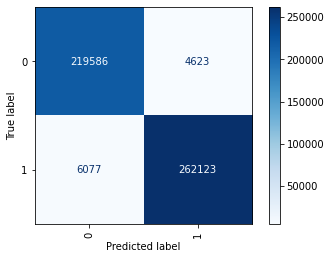

In [ ]:
plot_confusion_matrix(estimator=model, X= X_train_, y_true=y_train_, xticks_rotation='vertical', cmap='Blues', ax=None, include_values=True)

##Catboost

In [ ]:
X_train = X_train.fillna(0)
Y_train = Y_train.fillna(0)

In [ ]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train,Y_train, test_size=.2, random_state=555)

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

model = CatBoostClassifier()
catboost_model = model.fit(X_train_, y_train_)

#Predict
y_pred = catboost_model.predict(X_test_)

Learning rate set to 0.145398
0:	learn: 0.4147267	total: 390ms	remaining: 6m 29s
1:	learn: 0.2624790	total: 806ms	remaining: 6m 42s
2:	learn: 0.1906977	total: 1.26s	remaining: 6m 57s
3:	learn: 0.1385768	total: 1.58s	remaining: 6m 33s
4:	learn: 0.1083071	total: 1.79s	remaining: 5m 56s
5:	learn: 0.0935593	total: 1.91s	remaining: 5m 16s
6:	learn: 0.0819187	total: 2.04s	remaining: 4m 50s
7:	learn: 0.0756855	total: 2.17s	remaining: 4m 28s
8:	learn: 0.0711090	total: 2.4s	remaining: 4m 24s
9:	learn: 0.0679143	total: 2.65s	remaining: 4m 22s
10:	learn: 0.0650298	total: 2.91s	remaining: 4m 22s
11:	learn: 0.0629492	total: 3.21s	remaining: 4m 23s
12:	learn: 0.0614989	total: 3.54s	remaining: 4m 29s
13:	learn: 0.0601395	total: 3.84s	remaining: 4m 30s
14:	learn: 0.0582696	total: 4.08s	remaining: 4m 27s
15:	learn: 0.0575817	total: 4.41s	remaining: 4m 31s
16:	learn: 0.0565509	total: 4.79s	remaining: 4m 36s
17:	learn: 0.0560442	total: 5.26s	remaining: 4m 47s
18:	learn: 0.0550580	total: 5.57s	remaining: 

In [ ]:
print('Accuracy_score of CatBoost : %f'  %(accuracy_score(y_test_, y_pred)))

print(roc_auc_score(y_test_, y_pred))

Accuracy_score of CatBoost : 0.984899
0.9849907799747227


In [ ]:
model.fit(X_train, Y_train)
prediction = model.predict(X_test)

Learning rate set to 0.159933
0:	learn: 0.3949393	total: 163ms	remaining: 2m 42s
1:	learn: 0.2426274	total: 330ms	remaining: 2m 44s
2:	learn: 0.1737005	total: 476ms	remaining: 2m 38s
3:	learn: 0.1254081	total: 634ms	remaining: 2m 37s
4:	learn: 0.1030054	total: 783ms	remaining: 2m 35s
5:	learn: 0.0868551	total: 931ms	remaining: 2m 34s
6:	learn: 0.0760032	total: 1.07s	remaining: 2m 31s
7:	learn: 0.0710337	total: 1.23s	remaining: 2m 32s
8:	learn: 0.0676089	total: 1.39s	remaining: 2m 32s
9:	learn: 0.0646215	total: 1.54s	remaining: 2m 32s
10:	learn: 0.0624555	total: 1.7s	remaining: 2m 33s
11:	learn: 0.0597703	total: 1.85s	remaining: 2m 32s
12:	learn: 0.0583929	total: 2.02s	remaining: 2m 33s
13:	learn: 0.0575956	total: 2.17s	remaining: 2m 33s
14:	learn: 0.0568261	total: 2.32s	remaining: 2m 32s
15:	learn: 0.0559468	total: 2.49s	remaining: 2m 33s
16:	learn: 0.0551458	total: 2.65s	remaining: 2m 33s
17:	learn: 0.0547562	total: 2.78s	remaining: 2m 31s
18:	learn: 0.0542723	total: 2.94s	remaining: 

In [ ]:
df_sub = pd.DataFrame(prediction, columns=["category"])
df_sub.to_csv('output_cat.csv', float_format='%.6f', index_label="ID")

print("done.")

done.


##Adaboost

In [ ]:
#getting the required packages
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
#Using RandomizedSearchCV to get the best set of hyperparameter. 
ada = AdaBoostClassifier(random_state=0)
learning_rate=[0.01, 0.1, 1.0]
n_estimators=[10, 100, 500]
parameters = {'learning_rate': [0.01, 0.1, 1.0],'n_estimators' : [10, 100, 500]}
clf = RandomizedSearchCV(ada, parameters, scoring='f1_micro',cv=5, n_jobs=-1)
clf.fit(X_train, Y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=100)

In [ ]:
#evaluating the model on the best set of parameter found
model = AdaBoostClassifier(learning_rate=0.1, n_estimators = 100)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
n_scores = cross_val_score(model, X_train, Y_train, scoring='f1_micro', cv=cv)

# report performance
print(mean(n_scores))

0.9634281627791663

In [ ]:
#predicting the values on the test dataset
output = model.predict(X_test)
output = [int(i>0.5) for i in output]

In [ ]:
df_ada = pd.DataFrame(output, columns=["category"])
df_ada.to_csv('output.csv', float_format='%.6f', index_label="ID")

print("done.")

done.


##Neural Network

In [ ]:
#pip install keras

In [ ]:
#pip install Tensorflow

     |████████████████████████████████| 462 kB 4.4 MB/s 


In [ ]:
import keras
from keras.models import Sequential
from keras import backend as K
from keras.layers import Input, Embedding, Dropout, Conv1D, Conv2D, MaxPooling1D, Dense, Merge, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.merge import concatenate
from sklearn.metrics import f1_score
from keras.regularizers import l2
import pandas as pd
from sklearn import preprocessing
import numpy as np

In [ ]:
#my_optimizer = 'adam'
#N_VECTORIZATION = 15

In [ ]:
#path_to_data = "data/"

#training_set = pd.read_csv(path_to_data+"improved_training_set.csv")
#testing_set = pd.read_csv(path_to_data+"improved_testing_set.csv")

In [ ]:
#training_set = training_set.fillna(0)
#training_set[selected_features_global] = preprocessing.scale(training_set[selected_features])

#testing_set = testing_set.fillna(0)
#testing_set[selected_features_global] = preprocessing.scale(testing_set[selected_features])

In [ ]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [ ]:
#model = Sequential()

#model.add(Dense(1500, activation = "relu", input_dim=len(selected_features_global)))
#model.add(Dropout(0.5))

#model.add(Dense(1500, activation = "relu"))
#model.add(Dropout(0.5))

#model.add(Dense(1, activation = "sigmoid"))

In [ ]:
#model.compile(optimizer=my_optimizer,
 #             loss='binary_crossentropy',
  #            metrics=[f1])
#model.summary()

In [ ]:
#checkpoint = ModelCheckpoint("modelsNN/weights_1500_1500.{epoch:02d}-{f1:.4f}-{val_f1:.4f}.hdf5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
#model.fit(X_tr,Y_tr,batch_size=128,epochs=50,verbose=1,validation_data=(X_val, Y_val,), callbacks=[checkpoint])

In [ ]:
#predicted = model.predict(X_tst)
#predicted = [int(i>0.5) for i in predicted]

In [ ]:
#df_sub = pd.DataFrame(predicted,columns=["category"])

#df_sub.to_csv('output_NN.csv', float_format='%.6f', index_label="ID")
#print("done")